<a href="https://colab.research.google.com/github/Kzzrll/HMM3/blob/main/4_%22Intro_to_NN_3__hw__ipynb%22%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10.

In [ ]:
import tensorflow as tf

from tqdm import tqdm_notebook

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [ ]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

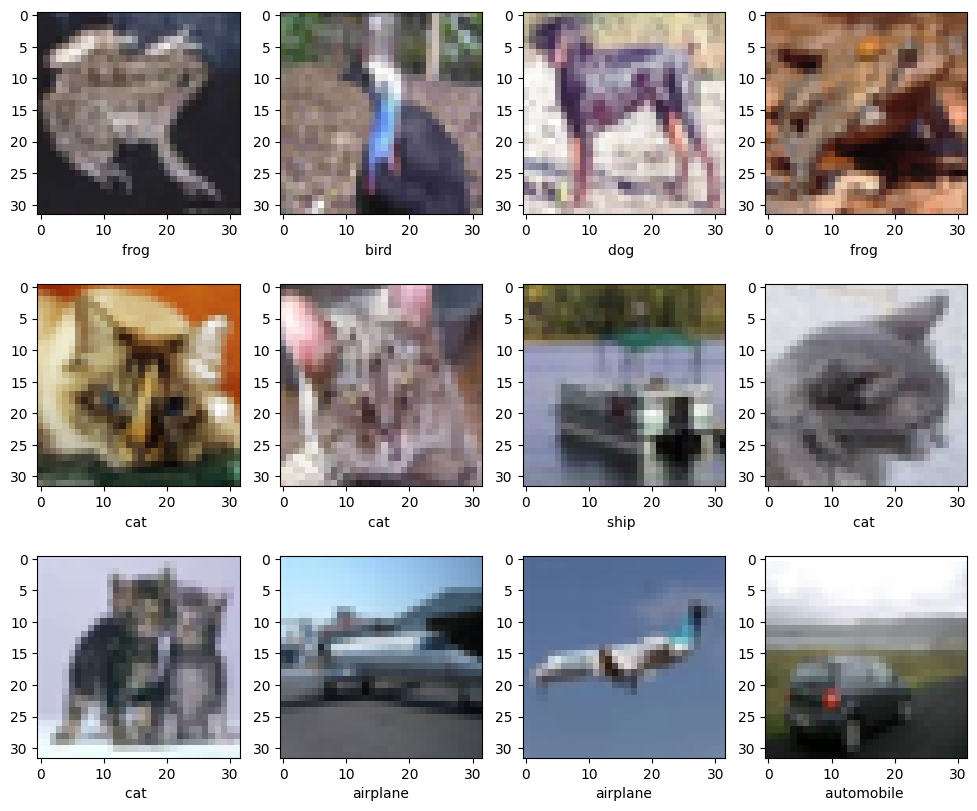

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [ ]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [ ]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [ ]:
import keras
from keras import layers as L
from keras import backend as K

In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')

])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Успех!


## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [ ]:
y_train, y_val = (keras.utils.to_categorical(y) for y in (y_train, y_val))

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
             tf.keras.callbacks.TensorBoard(log_dir='./logs'),
             tf.keras.callbacks.EarlyStopping(patience=3)]

In [ ]:
# Компиляция модели
model.compile(
    optimizer='sgd',  # стохастический градиентный спуск
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Обучение модели
model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=32,
    callbacks=callbacks,
    validation_data=(X_val, y_val),
    validation_split=0.2  #20% на валидацию
)




Epoch 1/32
2486/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2329 - loss: 2.0601

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.2333 - loss: 2.0593 - val_accuracy: 0.3825 - val_loss: 1.7331
Epoch 2/32
2498/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3909 - loss: 1.7042

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.3909 - loss: 1.7041 - val_accuracy: 0.4065 - val_loss: 1.6702
Epoch 3/32
2490/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4337 - loss: 1.5853

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.4337 - loss: 1.5853 - val_accuracy: 0.4537 - val_loss: 1.5474
Epoch 4/32
2496/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4607 - loss: 1.5205

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.4607 - loss: 1.5205 - val_accuracy: 0.4622 - val_loss: 1.5122
Epoch 5/32
2494/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4783 - loss: 1.4597

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.4783 - loss: 1.4597 - val_accuracy: 0.4807 - val_loss: 1.4688
Epoch 6/32
2486/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4918 - loss: 1.4170

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4919 - loss: 1.4170 - val_accuracy: 0.4613 - val_loss: 1.5048
Epoch 7/32
2487/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5062 - loss: 1.3773

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5063 - loss: 1.3773 - val_accuracy: 0.4849 - val_loss: 1.4610
Epoch 8/32
2489/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5227 - loss: 1.3422

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5228 - loss: 1.3421 - val_accuracy: 0.4942 - val_loss: 1.4399
Epoch 9/32
2491/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5348 - loss: 1.3044

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5348 - loss: 1.3044 - val_accuracy: 0.5049 - val_loss: 1.3962
Epoch 10/32
2499/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5485 - loss: 1.2722

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5485 - loss: 1.2723 - val_accuracy: 0.5031 - val_loss: 1.4106
Epoch 11/32
2494/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5569 - loss: 1.2428

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5569 - loss: 1.2428 - val_accuracy: 0.5153 - val_loss: 1.3803
Epoch 12/32
2484/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5678 - loss: 1.2169

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5677 - loss: 1.2170 - val_accuracy: 0.5127 - val_loss: 1.3966
Epoch 13/32
2483/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5777 - loss: 1.1945

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5778 - loss: 1.1945 - val_accuracy: 0.5189 - val_loss: 1.3765
Epoch 14/32
2483/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5833 - loss: 1.1679

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5833 - loss: 1.1679 - val_accuracy: 0.5240 - val_loss: 1.3623
Epoch 15/32
2494/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5970 - loss: 1.1322

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5970 - loss: 1.1322 - val_accuracy: 0.5256 - val_loss: 1.3736
Epoch 16/32
2487/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6074 - loss: 1.1041

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6073 - loss: 1.1042 - val_accuracy: 0.5085 - val_loss: 1.4155
Epoch 17/32
2484/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6155 - loss: 1.0807

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6155 - loss: 1.0808 - val_accuracy: 0.5180 - val_loss: 1.3943


А теперь можно проверить качество вашей сети, выполнив код ниже:

In [ ]:
# Проверка качества на тестовых данных
from sklearn.metrics import accuracy_score
import numpy as np

predict_x = model.predict(X_test)
classes_x = np.argmax(predict_x, axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

 Test_acc = 0.5194
 Not bad!


## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [ ]:
# Создаем последовательную модель
new_model = tf.keras.models.Sequential([
    # Свёрточный слой с 10 фильтрами 3x3
    tf.keras.layers.Conv2D(
        filters=10,
        kernel_size=(3, 3),
        padding='same',
        activation='relu',
        input_shape=X_train.shape[1:]
    ),

    # Max-pooling слой 2x2
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Преобразуем в вектор
    tf.keras.layers.Flatten(),

    # Полносвязный слой на 100 нейронов
    tf.keras.layers.Dense(100, activation='relu'),

    # Выходной слой с softmax
    tf.keras.layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Определяем колбэки для обучения
new_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='new_model.{epoch:02d}-{val_loss:.2f}.h5',
        save_best_only=True
    ),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),  # Логи для TensorBoard
    tf.keras.callbacks.EarlyStopping(
        patience=3,  # Остановится при отсутствии улучшения в течение 3 эпох
        monitor='val_loss',  # Мониторинг валидационной потери
        mode='min'  # Минимизация потери
    )
]


In [ ]:
# Компиляция модели
new_model.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Обучение модели
new_model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=32,
    callbacks=new_callbacks,
    validation_split=0.2  # 20% данных для валидации
)

Epoch 1/32
1992/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2666 - loss: 2.0254

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.2668 - loss: 2.0248 - val_accuracy: 0.4017 - val_loss: 1.6686
Epoch 2/32
1984/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4353 - loss: 1.5953

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4354 - loss: 1.5951 - val_accuracy: 0.4588 - val_loss: 1.5200
Epoch 3/32
1986/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4860 - loss: 1.4450

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4860 - loss: 1.4449 - val_accuracy: 0.4895 - val_loss: 1.4282
Epoch 4/32
1993/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5240 - loss: 1.3411

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5241 - loss: 1.3410 - val_accuracy: 0.5085 - val_loss: 1.3699
Epoch 5/32
1993/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5557 - loss: 1.2569

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5557 - loss: 1.2569 - val_accuracy: 0.5307 - val_loss: 1.3149
Epoch 6/32
1996/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5775 - loss: 1.1973

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5775 - loss: 1.1973 - val_accuracy: 0.5485 - val_loss: 1.2710
Epoch 7/32
1991/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6014 - loss: 1.1355

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6014 - loss: 1.1355 - val_accuracy: 0.5483 - val_loss: 1.2700
Epoch 8/32
1995/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6149 - loss: 1.0923

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6149 - loss: 1.0923 - val_accuracy: 0.5644 - val_loss: 1.2280
Epoch 9/32
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6329 - loss: 1.0474 - val_accuracy: 0.5540 - val_loss: 1.2629
Epoch 10/32
1992/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6417 - loss: 1.0190

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6417 - loss: 1.0190 - val_accuracy: 0.5745 - val_loss: 1.1992
Epoch 11/32
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6549 - loss: 0.9785 - val_accuracy: 0.5778 - val_loss: 1.2046
Epoch 12/32
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6727 - loss: 0.9245 - val_accuracy: 0.5863 - val_loss: 1.2005
Epoch 13/32
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6952 - loss: 0.8781 - val_accuracy: 0.5806 - val_loss: 1.2102


Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [ ]:
# Проверка качества на тестовых данных
from sklearn.metrics import accuracy_score
import numpy as np

predict_x = new_model.predict(X_test)
classes_x = np.argmax(predict_x, axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

 Test_acc = 0.5812
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций.

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [ ]:
class Evaluator(list):
    def __init__(self, models, optimizers='adam', loss=keras.losses.categorical_crossentropy,
                 metrics=[keras.metrics.categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        if not isinstance(models, dict):
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()])
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(self, X, y, validation_data=(), max_epochs=100, verbose=0, callbacks=[], batch_size=32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name, _ in self:
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name,
                  metric(y_test, model.predict(X_test).argmax(axis=1))))

In [ ]:
!rm -rf ./logs

In [ ]:
from tensorflow.keras import optimizers
from sklearn.metrics import accuracy_score
import numpy as np
import os

# Определяем различные оптимизаторы
optimizers = {
    'sgd': optimizers.SGD(),
    'momentum': optimizers.SGD(momentum=0.9),
    'adam': optimizers.Adam()
}

# Создаем экземпляр Evaluator
evaluator = Evaluator(
    models={'conv_model': new_model},  # Используем нашу сверточную модель
    optimizers=optimizers
)

# Обучаем модели
evaluator.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    max_epochs=10,
    batch_size=32
)



/tmp/ipython-input-2505868840.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Оцениваем качество на тестовых данных
evaluator.evaluate(X_test, y_test, accuracy_score)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Final score of conv_model_sgd is 0.5723
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Final score of conv_model_momentum is 0.5614
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Final score of conv_model_adam is 0.5976


Прокомментируйте полученные результаты.

С использованием разных оптимизаторов модель показывает разные score. adam  дает макс. score 0.5976

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [ ]:
import keras
from keras import layers as L
from keras.callbacks import EarlyStopping
from collections import OrderedDict

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)

    def add(self, layer):
        for name, model in self.items():
            model.add(layer)

    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# Пример использования:
models = Models(keras.Sequential())

# Нормализация входных данных
models.add(L.InputLayer(input_shape=(32, 32, 3)))
models.add(L.BatchNormalization())

# Свёрточный блок 1
models.add(L.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
models.add(L.MaxPooling2D(pool_size=(2, 2)))
models.add(L.Dropout(0.25))

# Свёрточный блок 2
models.add(L.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
models.add(L.MaxPooling2D(pool_size=(2, 2)))
models.add(L.Dropout(0.25))

# Полносвязный слой
models.add(L.Flatten())
models.add(L.Dense(512, activation='relu'))
models.add(L.Dropout(0.5))

# Выходной слой
models.add(L.Dense(10, activation='softmax'))

# Здесь создаём версии с BatchNormalization
models.add_create('conv_bn_1', L.BatchNormalization())
models.add_create('conv_bn_2', L.BatchNormalization())

# Настроим обучения
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

# Компиляция и обучение базовой модели
model_to_train = models['base_model']
model_to_train.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history = model_to_train.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

# Оценка на тестовых данных
test_loss, test_acc = model_to_train.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Оценка других моделей
for name, model in models.items():
    if name != 'base_model':
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
        print(f"Model {name} Test accuracy: {test_acc:.4f}")


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3424 - loss: 1.8465 - val_accuracy: 0.5597 - val_loss: 1.2326
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5613 - loss: 1.2324 - val_accuracy: 0.6514 - val_loss: 0.9938
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6332 - loss: 1.0392 - val_accuracy: 0.6730 - val_loss: 0.9345
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6702 - loss: 0.9436 - val_accuracy: 0.7072 - val_loss: 0.8441
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6967 - loss: 0.8660 - val_accuracy: 0.7174 - val_loss: 0.8089
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7146 - loss: 0.8001 - val_accuracy: 0.7215 - val_loss: 0.7975
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7337 - loss: 0.7589 - val_accuracy: 0.7339 - val_loss: 0.7700
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7499 - loss: 0.7106 - val_accuracy: 0

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

In [ ]:
import keras
from keras import layers as L
from keras.callbacks import EarlyStopping
from collections import OrderedDict
import numpy as np

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
            super().__init__(models)

    def add(self, layer):
        for name, model in self.items():
            model.add(layer)

    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# Создаем базовую модель
models = Models(keras.Sequential())

# Архитектура модели
models.add(L.InputLayer(input_shape=(32, 32, 3)))
models.add(L.Conv2D(32, (3, 3), padding='same', activation='relu'))
models.add(L.MaxPooling2D((2, 2)))
models.add(L.Conv2D(64, (3, 3), padding='same', activation='relu'))
models.add(L.MaxPooling2D((2, 2)))
models.add(L.Flatten())
models.add(L.Dense(128, activation='relu'))
models.add(L.Dense(10, activation='softmax'))

# Функция для тестирования разных batch_size
def test_batch_size(batch_size):
    # Компиляция модели
    model = models['base_model']
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

    # Настройка early stopping
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        min_delta=0.01,
        patience=5,
        restore_best_weights=True,
        baseline=0.55  # Остановка при достижении 55% точности
    )

    # Обучение модели
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Оценка на тестовых данных
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Batch size: {batch_size}, Test accuracy: {test_acc:.4f}")
    return test_acc

# Тестирование разных значений batch_size
batch_sizes_to_test = [32, 64, 128, 256, 512]
best_batch_size = None
best_accuracy = 0

for batch_size in batch_sizes_to_test:
    print(f"\nTesting batch size: {batch_size}")
    accuracy = test_batch_size(batch_size)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_batch_size = batch_size

print(f"\nBest batch size: {best_batch_size} with accuracy: {best_accuracy:.4f}")



Testing batch size: 32
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.4031 - loss: 1.6488 - val_accuracy: 0.5938 - val_loss: 1.1561
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6300 - loss: 1.0516 - val_accuracy: 0.6345 - val_loss: 1.0388
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6855 - loss: 0.8930 - val_accuracy: 0.6784 - val_loss: 0.9275
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7285 - loss: 0.7778 - val_accuracy: 0.6929 - val_loss: 0.8872
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7603 - loss: 0.6787 - val_accuracy: 0.7013 - val_loss: 0.8808
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7936 - loss: 0.5824 - val_accuracy: 0.7037 - val_loss: 0.8981
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8315 - loss: 0.4874 - val_accuracy: 0.7085 - val_loss: 0.9506
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - a

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

In [ ]:
import keras
from keras import layers as L
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from collections import OrderedDict
import numpy as np

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
            super().__init__(models)

    def add(self, layer):
        for name, model in self.items():
            model.add(layer)

    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})


models = Models(keras.Sequential())

# Архитектура модели
models.add(L.InputLayer(input_shape=(32, 32, 3)))
models.add(L.BatchNormalization())  # Начальная нормализация
models.add(L.Conv2D(32, (3, 3), padding='same', activation='relu'))
models.add(L.BatchNormalization())
models.add(L.MaxPooling2D((2, 2)))
models.add(L.Dropout(0.25))

models.add(L.Conv2D(64, (3, 3), padding='same', activation='relu'))
models.add(L.BatchNormalization())
models.add(L.MaxPooling2D((2, 2)))
models.add(L.Dropout(0.25))

models.add(L.Flatten())
models.add(L.Dense(128, activation='relu'))
models.add(L.BatchNormalization())
models.add(L.Dropout(0.5))
models.add(L.Dense(10, activation='softmax'))

# Настройка колбэков
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.00001
    )
]

# Функц для тестирования разных комбинаций
def test_optimizer_normalization(optimizer_name, use_bn):
    model = models['base_model']

    # Очщаем модель от BatchNormalization, если не нужно
    if not use_bn:
        model = keras.Sequential([layer for layer in model.layers if not isinstance(layer, L.BatchNormalization)])

    # Компиляция модели
    optimizer = {
        'adam': keras.optimizers.Adam(learning_rate=0.001),
        'rmsprop': keras.optimizers.RMSprop(learning_rate=0.001),
        'sgd': keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
        'adagrad': keras.optimizers.Adagrad(learning_rate=0.01)
    }[optimizer_name]

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Обучение
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    # Оценка
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Optimizer: {optimizer_name}, BN: {use_bn}, Test accuracy: {test_acc:.4f}")
    return test_acc, history




Testing Optimizer: adam, Use BN: True
Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3719 - loss: 1.9781 - val_accuracy: 0.5474 - val_loss: 1.2519 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5788 - loss: 1.2033 - val_accuracy: 0.6311 - val_loss: 1.0683 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6229 - loss: 1.0784 - val_accuracy: 0.6582 - val_loss: 1.0324 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6583 - loss: 0.9823 - val_accuracy: 0.6634 - val_loss: 1.0561 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6745 - loss: 0.9334 - val_accuracy: 0.6865 - val_loss: 0.8937 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6868 - loss: 0.8895 - val_accuracy: 0.7072 - val_loss: 0.8568 - learning_rate: 0.0010
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 3

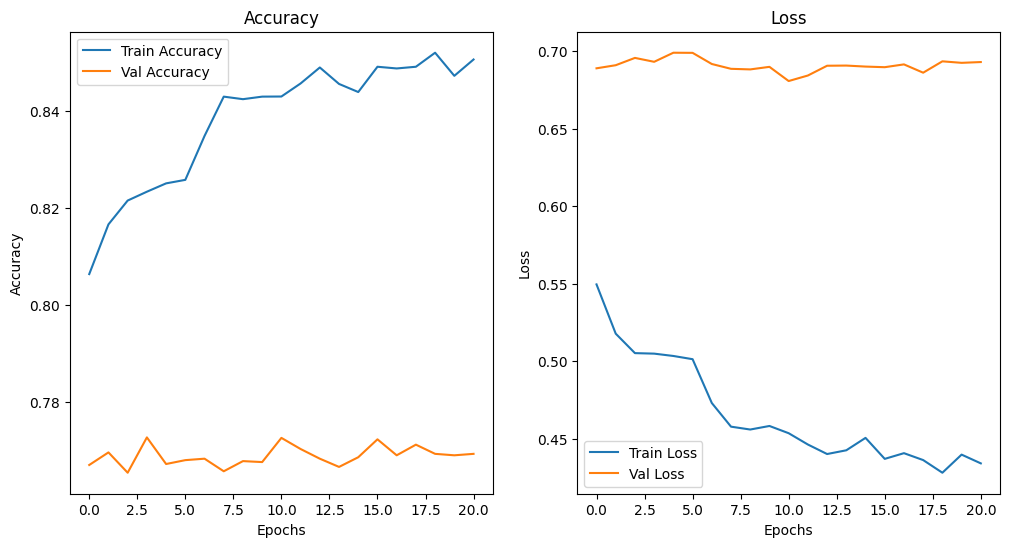

In [ ]:
# Тестирование комбинаций
best_accuracy = 0
best_config = None
results = {}

# Список оптимизаторов для тестирования
optimizers = ['adam', 'rmsprop', 'sgd', 'adagrad']

# Тестируем все комбинации
for optimizer in optimizers:
    for use_bn in [True, False]:
        print(f"\nTesting Optimizer: {optimizer}, Use BN: {use_bn}")
        accuracy, history = test_optimizer_normalization(optimizer, use_bn)

        # Сохран. результаты
        results[(optimizer, use_bn)] = {
            'accuracy': accuracy,
            'history': history
        }

        # Обновляем лучшую конфигурацию
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_config = (optimizer, use_bn)

# Вывод результатов
print("\nBest configuration found:")
print(f"Optimizer: {best_config[0]}, Use BN: {best_config[1]}")
print(f"Best accuracy: {best_accuracy:.4f}")

# Визуализация кривой обучения для лучшей модели
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Валидационная и обучающая точность
plt.subplot(1, 2, 1)
plt.plot(results[best_config]['history'].history['accuracy'], label='Train Accuracy')
plt.plot(results[best_config]['history'].history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Валидационная и обучающая потеря
plt.subplot(1, 2, 2)
plt.plot(results[best_config]['history'].history['loss'], label='Train Loss')
plt.plot(results[best_config]['history'].history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),]


In [ ]:
# увеличим количество фильтров с 10 до 20
model_man = keras.models.Sequential([
    L.InputLayer(input_shape=(32, 32, 3)),
    L.Conv2D(filters=20, kernel_size=(3, 3), padding='same', activation='relu'),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),

    L.Flatten(),
    L.Dense(100, activation='relu'),
    L.Dense(10, activation='softmax')])

model_man.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model_man.fit(X_train, y_train, epochs=5, batch_size=32,
          callbacks=callbacks, validation_data=(X_val, y_val))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 2.0864 - sparse_categorical_accuracy: 0.2420 - val_loss: 1.8369 - val_sparse_categorical_accuracy: 0.3565
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.6963 - sparse_categorical_accuracy: 0.4085 - val_loss: 1.6009 - val_sparse_categorical_accuracy: 0.4303
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.5255 - sparse_categorical_accuracy: 0.4590 - val_loss: 1.4173 - val_sparse_categorical_accuracy: 0.4928
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.3854 - sparse_categorical_accuracy: 0.5075 - val_loss: 1.3597 - val_sparse_categorical_accuracy: 0.5221
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.3129 - sparse_categorical_accuracy: 0.5370 - val_loss: 1.3156 - val_sparse_categorical_accuracy: 0.5484


На валидационной выборке accuracy = 0.5484

In [ ]:
# внесем еще один слой сверточной сети
model_man = keras.models.Sequential([
    L.InputLayer(input_shape=(32, 32, 3)),
    L.Conv2D(filters=20, kernel_size=(3, 3), padding='same', activation='relu'),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),

    L.Conv2D(filters=20, kernel_size=(3, 3), padding='same', activation='relu'),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),

    L.Flatten(),
    L.Dense(100, activation='relu'),
    L.Dense(10, activation='softmax')])

model_man.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model_man.fit(X_train, y_train, epochs=5, batch_size=32,
          callbacks=callbacks, validation_data=(X_val, y_val))

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 2.1410 - sparse_categorical_accuracy: 0.2195 - val_loss: 1.7451 - val_sparse_categorical_accuracy: 0.3840
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.7134 - sparse_categorical_accuracy: 0.3943 - val_loss: 1.5841 - val_sparse_categorical_accuracy: 0.4340
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.5252 - sparse_categorical_accuracy: 0.4553 - val_loss: 1.4236 - val_sparse_categorical_accuracy: 0.4979
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.4064 - sparse_categorical_accuracy: 0.4987 - val_loss: 1.3261 - val_sparse_categorical_accuracy: 0.5298
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.3045 - sparse_categorical_accuracy: 0.5368 - val_loss: 1.2655 - val_sparse_categorical_accuracy: 0.5485


На валидационной выборке accuracy = 0.5485. Точность валидации не изменилась.

In [ ]:
# добавить батч-норм между сверточным и полносвязным слоем
model_man = keras.models.Sequential([
    L.InputLayer(input_shape=(32, 32, 3)),
    L.Conv2D(filters=20, kernel_size=(3, 3), padding='same', activation='relu'),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.BatchNormalization(),
    L.Flatten(),
    L.Dense(100, activation='relu'),
    L.Dense(10, activation='softmax')])

model_man.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model_man.fit(X_train, y_train, epochs=5, batch_size=32,
          callbacks=callbacks, validation_data=(X_val, y_val))

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1.7167 - sparse_categorical_accuracy: 0.3910 - val_loss: 1.3635 - val_sparse_categorical_accuracy: 0.5205
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.2035 - sparse_categorical_accuracy: 0.5745 - val_loss: 1.4254 - val_sparse_categorical_accuracy: 0.5313
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.0223 - sparse_categorical_accuracy: 0.6429 - val_loss: 1.3315 - val_sparse_categorical_accuracy: 0.5379
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.8910 - sparse_categorical_accuracy: 0.6929 - val_loss: 1.1913 - val_sparse_categorical_accuracy: 0.5930
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7924 - sparse_categorical_accuracy: 0.7269 - val_loss: 1.1761 - val_sparse_categorical_accuracy: 0.6014


На валидационной выборке accuracy = 0.6014. Значительное улучшение валидационной точности до 60.14%. Высокая точность на обучающей выборке 72.69%.

In [ ]:
# добавить батч-норм перед выходным слоем
model_man = keras.models.Sequential([
    L.InputLayer(input_shape=(32, 32, 3)),
    L.Conv2D(filters=20, kernel_size=(3, 3), padding='same', activation='relu'),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.BatchNormalization(),
    L.Flatten(),
    L.Dense(100, activation='relu'),
    L.BatchNormalization(),
    L.Dense(10, activation='softmax')])

model_man.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model_man.fit(X_train, y_train, epochs=5, batch_size=32,
          callbacks=callbacks, validation_data=(X_val, y_val))

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1.7365 - sparse_categorical_accuracy: 0.3868 - val_loss: 1.4356 - val_sparse_categorical_accuracy: 0.4917
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.2472 - sparse_categorical_accuracy: 0.5583 - val_loss: 1.3324 - val_sparse_categorical_accuracy: 0.5360
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.0932 - sparse_categorical_accuracy: 0.6185 - val_loss: 1.2892 - val_sparse_categorical_accuracy: 0.5549
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.9973 - sparse_categorical_accuracy: 0.6532 - val_loss: 1.5962 - val_sparse_categorical_accuracy: 0.4557
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.9092 - sparse_categorical_accuracy: 0.6832 - val_loss: 1.2430 - val_sparse_categorical_accuracy: 0.5872


На валидационной выборке accuracy = 0.5872. Точность несколько ниже, чем в предыдущем варианте


In [ ]:
# изменение батч-сайз на 16
model_man = keras.models.Sequential([
    L.InputLayer(input_shape=(32, 32, 3)),
    L.Conv2D(filters=20, kernel_size=(3, 3), padding='same', activation='relu'),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.BatchNormalization(),
    L.Flatten(),
    L.Dense(100, activation='relu'),
    L.Dense(10, activation='softmax')])

model_man.compile(optimizer='sgd', loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'] )
model_man.fit(X_train, y_train, epochs=5, batch_size=16,
          callbacks=callbacks, validation_data=(X_val, y_val))

Epoch 1/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1.6880 - sparse_categorical_accuracy: 0.4044 - val_loss: 1.4648 - val_sparse_categorical_accuracy: 0.5015
Epoch 2/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.1298 - sparse_categorical_accuracy: 0.6035 - val_loss: 1.1669 - val_sparse_categorical_accuracy: 0.5856
Epoch 3/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.9247 - sparse_categorical_accuracy: 0.6762 - val_loss: 1.0756 - val_sparse_categorical_accuracy: 0.6241
Epoch 4/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.7837 - sparse_categorical_accuracy: 0.7304 - val_loss: 1.1528 - val_sparse_categorical_accuracy: 0.6166
Epoch 5/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6658 - sparse_categorical_accuracy: 0.7688 - val_loss: 1.1338 - val_sparse_categorical_accuracy: 0.6290


На валидационной выборке accuracy = 0.6290. Высокая точность на обучающей выборке 78.89%.

In [ ]:
# увеличение  числа эпох до 10
model_man = keras.models.Sequential([
    L.InputLayer(input_shape=(32, 32, 3)),
    L.Conv2D(filters=20, kernel_size=(3, 3), padding='same', activation='relu'),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.BatchNormalization(),
    L.Flatten(),
    L.Dense(100, activation='relu'),
    L.Dense(10, activation='softmax')])

model_man.compile(optimizer='sgd', loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'] )
model_man.fit(X_train, y_train, epochs=10, batch_size=32,
          callbacks=callbacks, validation_data=(X_val, y_val))

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.7240 - sparse_categorical_accuracy: 0.3915 - val_loss: 1.4127 - val_sparse_categorical_accuracy: 0.5032
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.2129 - sparse_categorical_accuracy: 0.5701 - val_loss: 1.2505 - val_sparse_categorical_accuracy: 0.5571
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.0473 - sparse_categorical_accuracy: 0.6321 - val_loss: 1.2291 - val_sparse_categorical_accuracy: 0.5741
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.9095 - sparse_categorical_accuracy: 0.6823 - val_loss: 1.1349 - val_sparse_categorical_accuracy: 0.6079
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8147 - sparse_categorical_accuracy: 0.7179 - val_loss: 1.2902 - val_sparse_categorical_accuracy: 0.5675
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7239 - sparse_categorical_accuracy: 0.7489 - val_loss: 1.1680 - val_sparse_categorical_accuracy:

accuracy = 0.6168. Несколько ниже значение.

In [ ]:
# уберем callbacks и добавим количестов эпох до 20
model_man = keras.models.Sequential([
    L.InputLayer(input_shape=(32, 32, 3)),
    L.Conv2D(filters=20, kernel_size=(3, 3), padding='same', activation='relu'),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),

    L.BatchNormalization(),
    L.Flatten(),
    L.Dense(100, activation='relu'),
    L.Dense(10, activation='softmax')])

model_man.compile(optimizer='sgd', loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'] )
model_man.fit(X_train, y_train, epochs=20, batch_size=32,
           validation_data=(X_val, y_val))

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.6950 - sparse_categorical_accuracy: 0.3936 - val_loss: 1.3139 - val_sparse_categorical_accuracy: 0.5402
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.1764 - sparse_categorical_accuracy: 0.5865 - val_loss: 1.4201 - val_sparse_categorical_accuracy: 0.5143
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.0155 - sparse_categorical_accuracy: 0.6439 - val_loss: 1.1238 - val_sparse_categorical_accuracy: 0.6066
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.9038 - sparse_categorical_accuracy: 0.6876 - val_loss: 1.1553 - val_sparse_categorical_accuracy: 0.6017
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7933 - sparse_categorical_accuracy: 0.7281 - val_loss: 1.1857 - val_sparse_categorical_accuracy: 0.6064
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7085 - sparse_categorical_accuracy: 0.7571 - val_loss: 1.1835 - val_sparse_categorical_accuracy:

accuracy = 0.6190. С увеличением колическтва эпох качество несколько выросло. Высокая точность на обучающей выборке 98.64%.

In [ ]:
# добавим еще сверточный слой и батч-норм
model_man = keras.models.Sequential([
    L.InputLayer(input_shape=(32, 32, 3)),
    L.Conv2D(filters=20, kernel_size=(3, 3), padding='same', activation='relu'),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.BatchNormalization(),

    L.Conv2D(filters=20, kernel_size=(3, 3), padding='same', activation='relu'),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.BatchNormalization(),

    L.Flatten(),
    L.Dense(100, activation='relu'),
    L.Dense(10, activation='softmax')])

model_man.compile(optimizer='sgd', loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'] )
model_man.fit(X_train, y_train, epochs=20, batch_size=32,
           validation_data=(X_val, y_val))

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.7548 - sparse_categorical_accuracy: 0.3754 - val_loss: 1.3794 - val_sparse_categorical_accuracy: 0.5134
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.2366 - sparse_categorical_accuracy: 0.5586 - val_loss: 1.2261 - val_sparse_categorical_accuracy: 0.5666
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.1103 - sparse_categorical_accuracy: 0.6056 - val_loss: 1.3295 - val_sparse_categorical_accuracy: 0.5396
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.0216 - sparse_categorical_accuracy: 0.6377 - val_loss: 1.0675 - val_sparse_categorical_accuracy: 0.6228
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.9416 - sparse_categorical_accuracy: 0.6708 - val_loss: 1.1664 - val_sparse_categorical_accuracy: 0.5959
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.8749 - sparse_categorical_accuracy: 0.6911 - val_loss: 1.0160 - val_sparse_categorical_accuracy

accuracy = 0.6596 на валидационной выборке. точность на обучающей  88.65%.

In [ ]:
# добавим Dropout
model_man = keras.models.Sequential([
    L.InputLayer(input_shape=(32, 32, 3)),

    L.Conv2D(filters=20, kernel_size=(3, 3), padding='same', activation='relu'),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.BatchNormalization(),
    L.Dropout(0.2),

    L.Conv2D(filters=20, kernel_size=(3, 3), padding='same', activation='relu'),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.BatchNormalization(),

    L.Flatten(),
    L.Dense(100, activation='relu'),
    L.Dense(10, activation='softmax')])

model_man.compile(optimizer='sgd', loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'] )
model_man.fit(X_train, y_train, epochs=20, batch_size=32,
           validation_data=(X_val, y_val))

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 1.8064 - sparse_categorical_accuracy: 0.3634 - val_loss: 1.4481 - val_sparse_categorical_accuracy: 0.4855
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.2932 - sparse_categorical_accuracy: 0.5338 - val_loss: 1.3990 - val_sparse_categorical_accuracy: 0.5119
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.1453 - sparse_categorical_accuracy: 0.5943 - val_loss: 1.1355 - val_sparse_categorical_accuracy: 0.5965
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.0642 - sparse_categorical_accuracy: 0.6217 - val_loss: 1.1658 - val_sparse_categorical_accuracy: 0.5947
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.0006 - sparse_categorical_accuracy: 0.6465 - val_loss: 1.0744 - val_sparse_categorical_accuracy: 0.6275
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.9442 - sparse_categorical_accuracy: 0.6694 - val_loss: 1.0061 - val_sparse_categorical_accuracy:

accuracy = 0.7042.

In [ ]:
# добавим еще один полносвязный слой
model_man = keras.models.Sequential([
    L.InputLayer(input_shape=(32, 32, 3)),

    L.Conv2D(filters=20, kernel_size=(3, 3), padding='same', activation='relu'),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.BatchNormalization(),
    L.Dropout(0.2),

    L.Conv2D(filters=20, kernel_size=(3, 3), padding='same', activation='relu'),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.BatchNormalization(),


    L.Flatten(),
    L.Dense(100, activation='relu'),
    L.Dense(100, activation='relu'),
    L.Dense(10, activation='softmax')])

model_man.compile(optimizer='sgd', loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'] )
model_man.fit(X_train, y_train, epochs=20, batch_size=32,
           validation_data=(X_val, y_val))

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 1.8310 - sparse_categorical_accuracy: 0.3396 - val_loss: 1.5342 - val_sparse_categorical_accuracy: 0.4588
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.3038 - sparse_categorical_accuracy: 0.5292 - val_loss: 1.4320 - val_sparse_categorical_accuracy: 0.5029
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.1485 - sparse_categorical_accuracy: 0.5923 - val_loss: 1.2615 - val_sparse_categorical_accuracy: 0.5492
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.0489 - sparse_categorical_accuracy: 0.6269 - val_loss: 1.1213 - val_sparse_categorical_accuracy: 0.6029
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.9676 - sparse_categorical_accuracy: 0.6569 - val_loss: 1.0063 - val_sparse_categorical_accuracy: 0.6381
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.9162 - sparse_categorical_accuracy: 0.6746 - val_loss: 1.0535 - val_sparse_categorical_accurac

accuracy: = 0.6909

In [ ]:
# добавим Dropout в полносвязный слой
model_man = keras.models.Sequential([
    L.InputLayer(input_shape=(32, 32, 3)),


    L.Conv2D(filters=20, kernel_size=(3, 3), padding='same', activation='relu'),

    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.BatchNormalization(),
    L.Dropout(0.2),

    L.Conv2D(filters=20, kernel_size=(3, 3), padding='same', activation='relu'),

    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.BatchNormalization(),


    L.Flatten(),
    L.Dense(100, activation='relu'),
    L.Dropout(0.2),
    L.Dense(100, activation='relu'),
    L.Dropout(0.2),

    L.Dense(10, activation='softmax')])

model_man.compile(optimizer='sgd', loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'] )
model_man.fit(X_train, y_train, epochs=20, batch_size=32,
           validation_data=(X_val, y_val))

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 1.9968 - sparse_categorical_accuracy: 0.2807 - val_loss: 1.5261 - val_sparse_categorical_accuracy: 0.4539
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.5499 - sparse_categorical_accuracy: 0.4386 - val_loss: 1.3739 - val_sparse_categorical_accuracy: 0.5046
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.4020 - sparse_categorical_accuracy: 0.4935 - val_loss: 1.2760 - val_sparse_categorical_accuracy: 0.5454
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.3217 - sparse_categorical_accuracy: 0.5266 - val_loss: 1.3302 - val_sparse_categorical_accuracy: 0.5320
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 1.2536 - sparse_categorical_accuracy: 0.5489 - val_loss: 1.1718 - val_sparse_categorical_accuracy: 0.5828
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.1893 - sparse_categorical_accuracy: 0.5701 - val_loss: 1.9378 - val_sparse_categorical_accurac

accuracy: 0.6999

In [ ]:
# добавим несоклько сверточных слоев с макспулингом и батчнормом и дропаутом
model_man = keras.models.Sequential([
    L.InputLayer(input_shape=(32, 32, 3)),
    #####################

    L.Conv2D(filters=20,  kernel_size=(3, 3), padding='same', activation='relu'),
    L.BatchNormalization(),
    L.Conv2D(filters=20, kernel_size=(3, 3), padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=(2, 2), padding='same'),

    L.Dropout(0.2),
    L.Conv2D(filters=40,  kernel_size=(3, 3), padding='same', activation='relu'),
    L.BatchNormalization(),
    L.Conv2D(filters=40,  kernel_size=(3, 3), padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=(2, 2), padding='same'),

    L.Dropout(0.3),
    L.Conv2D(filters=80, kernel_size=(3, 3), padding='same', activation='relu'),
    L.BatchNormalization(),
    L.Conv2D(filters=80, kernel_size=(3, 3), padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=(2, 2), padding='same'),

    L.Dropout(0.3),
    L.Conv2D(filters=160, kernel_size=(3, 3), padding='same', activation='relu'),
    L.BatchNormalization(),
    L.Conv2D(filters=160, kernel_size=(3, 3), padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=(2, 2), padding='same'),
    L.BatchNormalization(),

    L.Dropout(0.3),
    L.Conv2D(filters=320, kernel_size=(3, 3), padding='same', activation='relu'),
    L.BatchNormalization(),
    L.Conv2D(filters=320, kernel_size=(3, 3), padding='same', activation='relu'),
    L.BatchNormalization(),

    L.Dropout(0.3),
    L.Conv2D(filters=640, kernel_size=(3, 3), padding='same', activation='relu'),
    L.BatchNormalization(),
    L.Conv2D(filters=640, kernel_size=(3, 3), padding='same', activation='relu'),
    L.BatchNormalization(),

    L.Dropout(0.2),
    ############################
    L.Flatten(),
    L.Dense(640, activation='relu'),
    L.BatchNormalization(),
    L.Dropout(0.2),
    L.Dense(10, activation='softmax')])

model_man.compile(optimizer='sgd', loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'] )
model_man.fit(X_train, y_train, epochs=40, batch_size=32,
           validation_data=(X_val, y_val))

Epoch 1/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - loss: 2.2979 - sparse_categorical_accuracy: 0.2562 - val_loss: 1.6717 - val_sparse_categorical_accuracy: 0.4133
Epoch 2/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 1.5633 - sparse_categorical_accuracy: 0.4307 - val_loss: 1.5355 - val_sparse_categorical_accuracy: 0.4634
Epoch 3/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 1.3700 - sparse_categorical_accuracy: 0.5050 - val_loss: 1.3303 - val_sparse_categorical_accuracy: 0.5272
Epoch 4/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 1.2498 - sparse_categorical_accuracy: 0.5573 - val_loss: 1.4149 - val_sparse_categorical_accuracy: 0.5263
Epoch 5/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 1.1555 - sparse_categorical_accuracy: 0.5926 - val_loss: 1.0871 - val_sparse_categorical_accuracy: 0.6172
Epoch 6/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 1.0626 - sparse_categorical_accuracy: 0.6210 - val_loss: 1.0095 - val_sparse_categoric

Момент истины: проверьте, какого качества достигла ваша сеть.

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model_man.predict(X_test), axis=-1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

 Test_acc = 0.8177
Это победа!


***Test_acc = 0.8177. Получилось больше 80 %
Теперь попробуем и с аугментацией***

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False
)

datagen.fit(X_train)


In [ ]:
#
model_man = keras.models.Sequential([
    L.InputLayer(input_shape=(32, 32, 3)),
    #####################

    L.Conv2D(filters=20,  kernel_size=(3, 3), padding='same', activation='relu'),
    L.BatchNormalization(),
    L.Conv2D(filters=20, kernel_size=(3, 3), padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=(2, 2), padding='same'),

    L.Dropout(0.2),
    L.Conv2D(filters=40,  kernel_size=(3, 3), padding='same', activation='relu'),
    L.BatchNormalization(),
    L.Conv2D(filters=40,  kernel_size=(3, 3), padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=(2, 2), padding='same'),

    L.Dropout(0.3),
    L.Conv2D(filters=80, kernel_size=(3, 3), padding='same', activation='relu'),
    L.BatchNormalization(),
    L.Conv2D(filters=80, kernel_size=(3, 3), padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=(2, 2), padding='same'),

    L.Dropout(0.3),
    L.Conv2D(filters=160, kernel_size=(3, 3), padding='same', activation='relu'),
    L.BatchNormalization(),
    L.Conv2D(filters=160, kernel_size=(3, 3), padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=(2, 2), padding='same'),
    L.BatchNormalization(),

    L.Dropout(0.3),
    L.Conv2D(filters=320, kernel_size=(3, 3), padding='same', activation='relu'),
    L.BatchNormalization(),
    L.Conv2D(filters=320, kernel_size=(3, 3), padding='same', activation='relu'),
    L.BatchNormalization(),

    L.Dropout(0.3),
    L.Conv2D(filters=640, kernel_size=(3, 3), padding='same', activation='relu'),
    L.BatchNormalization(),
    L.Conv2D(filters=640, kernel_size=(3, 3), padding='same', activation='relu'),
    L.BatchNormalization(),

    #L.Dropout(0.2),
    ############################
    L.Flatten(),
    L.Dense(640, activation='relu'),
    L.BatchNormalization(),
    L.Dropout(0.2),
    L.Dense(10, activation='softmax')])

model_man.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'] )
model_man.fit(datagen.flow(X_train, y_train, batch_size = 32), epochs=40, validation_data=(X_val, y_val))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/40


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 29ms/step - loss: 2.2678 - sparse_categorical_accuracy: 0.2546 - val_loss: 1.7914 - val_sparse_categorical_accuracy: 0.3813
Epoch 2/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - loss: 1.6815 - sparse_categorical_accuracy: 0.3992 - val_loss: 1.7237 - val_sparse_categorical_accuracy: 0.4016
Epoch 3/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - loss: 1.5252 - sparse_categorical_accuracy: 0.4505 - val_loss: 1.5251 - val_sparse_categorical_accuracy: 0.4858
Epoch 4/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - loss: 1.3898 - sparse_categorical_accuracy: 0.5022 - val_loss: 1.4870 - val_sparse_categorical_accuracy: 0.5150
Epoch 5/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - loss: 1.3115 - sparse_categorical_accuracy: 0.5348 - val_loss: 1.4792 - val_sparse_categorical_accuracy: 0.5013
Epoch 6/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - loss: 1.2346 - sparse_categorical_accuracy: 0.5605 - val_loss: 1.1031 - val_sparse_categorical_accuracy

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model_man.predict(X_test), axis=-1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

 Test_acc = 0.7623


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов.

На повышение качества влияет увеличение числа сверточных слоев и увеличение количества эпох. Так же число фильтров и Батчнорм. Положительного влияния агментации не выявлено.